# Learning to Rank with Python

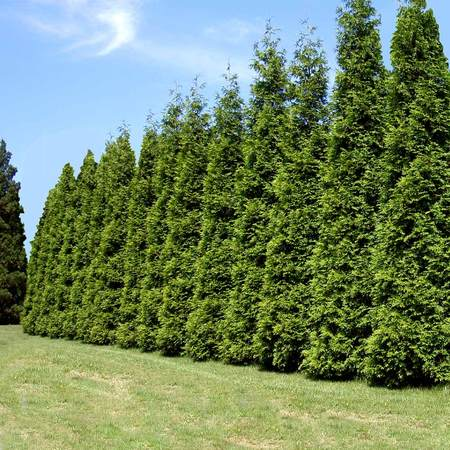

In [1]:
# file: ranking_algorithms_in_python.ipynb
# poc: mlrosewin@gmail.com
# date: jan 2021

from IPython.display import Image
Image(filename='ltr_trees.jpg', width=400, height=300)

## Introduction

Learning to Rank (LTR) algorithms are an interesting and useful sub-branch of machine learning. In this notebook we are going to explore several of these algorithms and have some fun with an open source ranking benchmark dataset.

### Library Imports

In this notebook we will focus on the ranking algorithms implemented in the gradient boosting library XGBoost (https://github.com/dmlc/xgboost). XGBoost provides a short boosting tutorial (https://github.com/dmlc/xgboost/tree/master/demo/rank) that you might want to take a look at. In this notebook we will use a different dataset and workflow from the XGBoost tutorial.

We import the standard Python numeric (numpy), data manipulation (pandas) and visualization (matplotlib, seaborn) libraries. xgboost is our main modeling library, bringing in a few sklearn tools for scoring our model

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Ranking model
import xgboost as xgb
from xgboost import DMatrix

# Evaluating the ranking model
from sklearn.metrics import dcg_score
from sklearn.metrics import ndcg_score

from sklearn.metrics import mean_squared_error

### Data ingest

We use a portion of the . . . dataset . . . 

In [3]:
#df_train = pd.read_csv('./data/data_train_letor_cleaned_2021JAN14_10K.csv')
#df_test = pd.read_csv('./data/data_test_letor_cleaned_2021JAN14_10K.csv')

df_train = pd.read_csv('./data/data_train_letor_cleaned_2021JAN14.csv')
df_test = pd.read_csv('./data/data_test_letor_cleaned_2021JAN14.csv')

df_train = df_train.head(10000) # better to keep ordering for groups
df_test = df_test.head(10000)

print(df_train.shape, df_train.columns)
df_train.head(2)

(10000, 138) Index(['covered query term number: body', 'covered query term number: anchor',
       'covered query term number: title', 'covered query term number: url',
       'covered query term number: whole document',
       'covered query term ratio: body', 'covered query term ratio: anchor',
       'covered query term ratio: title', 'covered query term ratio: url',
       'covered query term ratio: whole document',
       ...
       'Outlink number', 'PageRank', 'SiteRank', 'QualityScore',
       'QualityScore2', 'Query-url click count', 'url click count',
       'url dwell time', 'Label', 'group'],
      dtype='object', length=138)


,covered query term number: body,covered query term number: anchor,covered query term number: title,covered query term number: url,covered query term number: whole document,covered query term ratio: body,covered query term ratio: anchor,covered query term ratio: title,covered query term ratio: url,covered query term ratio: whole document,...,Outlink number,PageRank,SiteRank,QualityScore,QualityScore2,Query-url click count,url click count,url dwell time,Label,group
0,3.0,3.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,1.0,...,2.0,116.0,64034.0,13.0,3.0,0.0,0.0,0.0,2.0,1
1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,0.0,1.0,...,2.0,124.0,64034.0,1.0,2.0,0.0,0.0,0.0,2.0,1


### Prepare data for machine learning

In [4]:
df_y_train = df_train['Label']
df_X_train = df_train.drop(columns=['Label', 'group'])
print(df_train.shape, df_X_train.shape, df_y_train.shape)

df_y_test = df_test['Label']
df_X_test = df_test.drop(columns=['Label', 'group'])
df_g_test = df_test['group']
print(df_test.shape, df_X_test.shape, df_y_test.shape)

(10000, 138) (10000, 136) (10000,)
(10000, 138) (10000, 136) (10000,)


In [5]:
X_train = df_X_train.values
y_train = df_y_train.values

X_test = df_X_test.values
y_test = df_y_test.values
g_test = df_g_test.values

training_data = DMatrix(X_train, y_train)
testing_data = DMatrix(X_test, y_test)

#### Extract and set group sizes

(explain roughly what mean by group = query response, etc . . . )

In [6]:
def get_group_sizes(df):
    '''
    '''
    grps_uniq = df['group'].unique()
    grp_sizes = []
    for grp in grps_uniq:
        df_grp = df[df['group'] == grp]
        grp_sizes.append(df_grp.shape[0])
        
    return grp_sizes

In [7]:
train_group_sizes = get_group_sizes(df_train)
test_group_sizes = get_group_sizes(df_test)

In [8]:
testing_data.set_group(g_test) # is this correct?

training_data.set_group(train_group_sizes)
testing_data.set_group(test_group_sizes)

### Train ranking model

In [9]:
#param = {'max_depth':6, 'eta':0.3, 'objective':'rank:pairwise'} # 'num_round':10'silent':0
#param = {'max_depth':6, 'eta':0.3, 'objective':'rank:map'}
param = {'max_depth':6, 'eta':0.3, 'objective':'rank:ndcg'}
model = xgb.train(param, training_data);
preds_train = model.predict(training_data)
preds_test = model.predict(testing_data)
df_train['preds'] = preds_train
df_test['preds'] = preds_test

### Evaluate the ranking

In [10]:
def score_ranking(df_all):
    '''
    '''
    df_all = df_all.copy()
    ndcg_score_1 = []
    ndcg_score_vec = []

    for group in df_all['group'].unique():
        df_grp = []
        ndcg_score_1 = []
        df_grp = df_all[df_all['group'] == group]
        ndcg_score_1 = ndcg_score([df_grp['Label'].to_list()], 
                                  [df_grp['preds'].to_list()])
        ndcg_score_vec.append(ndcg_score_1)
    
    return ndcg_score_vec

In [11]:
ndcg_scores_test = score_ranking(df_test)
ndcg_scores_train = score_ranking(df_train)

In [12]:
print(np.mean(ndcg_scores_train), np.median(ndcg_scores_train))
print(np.mean(ndcg_scores_test), np.median(ndcg_scores_test))

0.794118670986766 0.8262231347711521
0.7109797532235567 0.7318333058990729


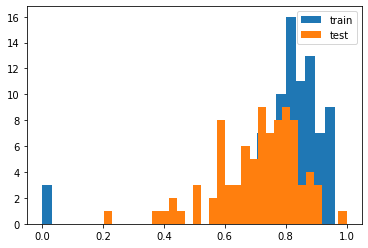

In [13]:
plt.figure()
plt.hist(ndcg_scores_train, bins=30, label='train');
plt.hist(ndcg_scores_test, bins=30, label='test');
plt.legend()

### Compare to regression or classification baseline

In [14]:
xg_reg = xgb.XGBRegressor(max_depth=6)
xg_reg.fit(X_train, y_train)

y_pred_test = xg_reg.predict(X_test)

In [15]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE: %f" % (rmse))

RMSE: 0.774321


In [16]:
y_pred_test

array([0.35023522, 0.50140774, 1.0378476 , ..., 0.74990034, 0.16465142,
       0.77271676], dtype=float32)

In [17]:
y_test

array([2., 1., 3., ..., 1., 1., 1.])